In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv("train.csv")
dig_mnist = pd.read_csv("Dig-MNIST.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dig_mnist.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_df.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y_train = train_df["label"].values
y_val = dig_mnist["label"].values

In [7]:
x_train = train_df[train_df.keys().drop(["label"])].values
x_val = dig_mnist[dig_mnist.keys().drop(["label"])].values
x_test = test_df[test_df.keys().drop(["id"])].values

In [8]:
x_test.shape

(5000, 784)

In [9]:
x_train = x_train.reshape(-1,28,28,1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28,28, 1)

In [10]:
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

In [11]:
x_train.shape, x_val.shape, x_test.shape

((60000, 28, 28, 1), (10240, 28, 28, 1), (5000, 28, 28, 1))

In [12]:
set(y_train), set(y_val)

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

In [13]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [14]:
y_train.shape, y_val.shape

((60000, 10), (10240, 10))

In [15]:
y_val[6]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

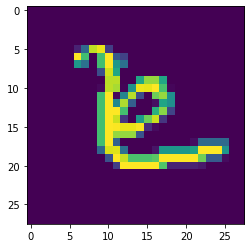

In [16]:
plt.imshow(x_val[6][:,:,0])

In [17]:
y_train[6]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

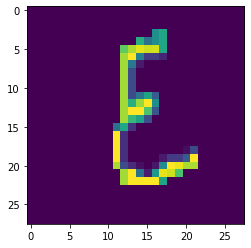

In [18]:
plt.imshow(x_train[6][:,:,0])

In [19]:
def plot_data(number):
    rows = 2
    columns = 5
    fig, ax = plt.subplots(nrows=rows, ncols=columns+1, figsize=(20,20))
    fig.tight_layout()
    j = 0
    for i in range(number, 10*columns+1, 10):
        ax[0][j].imshow(x_train[i][:,:,0])
        ax[1][j].imshow(x_val[i][:,:,0])
        j+=1

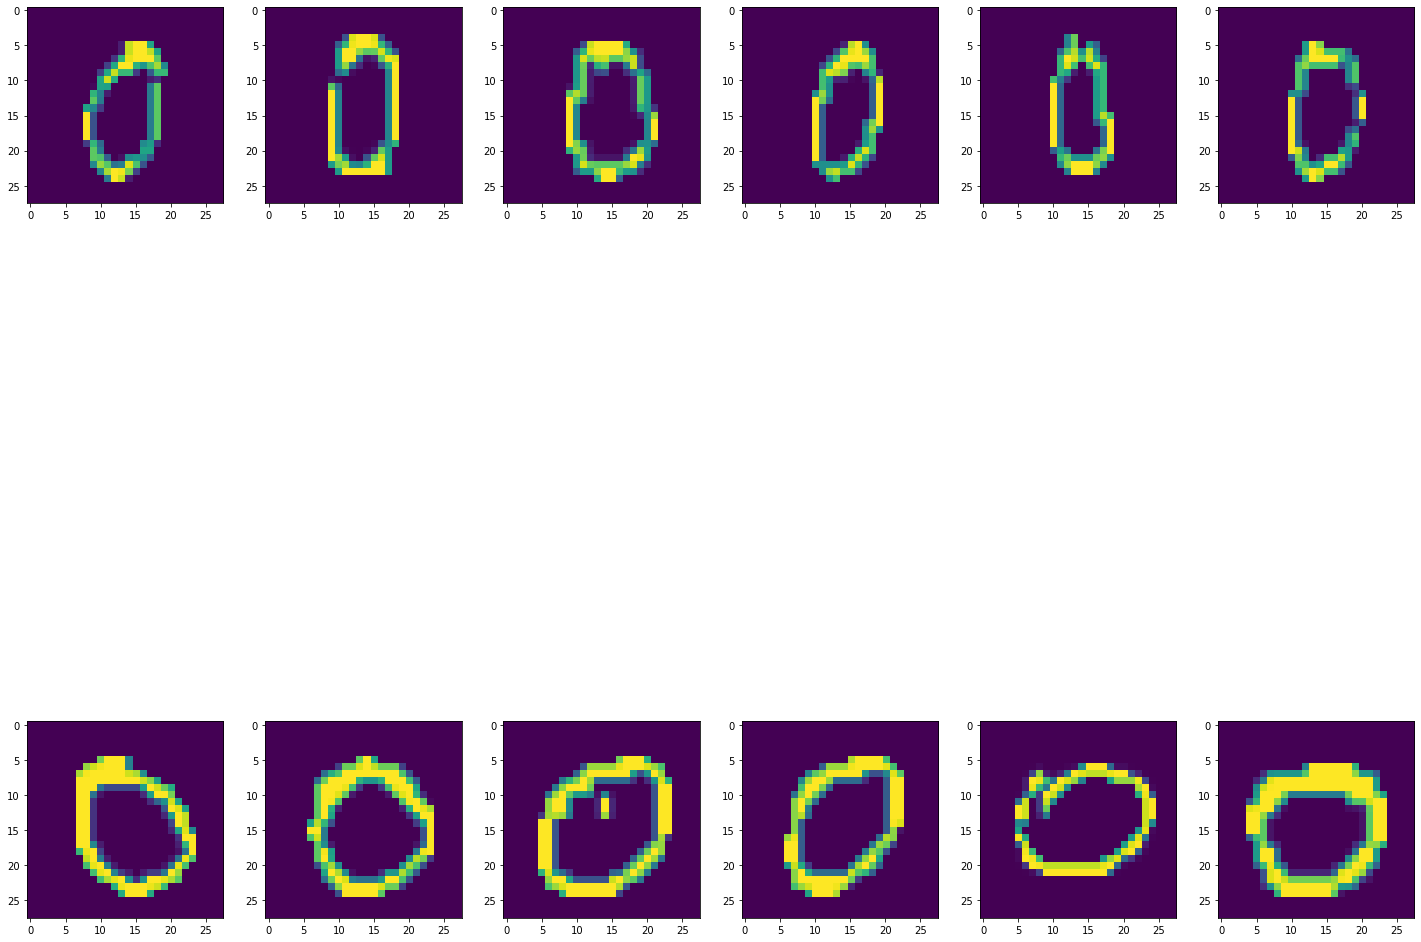

In [20]:
plot_data(number=0)

In [21]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size=(3,3), padding="same", activation="relu",
                     input_shape=(28,28,1), kernel_initializer="glorot_uniform"))
    model.add(Conv2D(filters = 16, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Conv2D(filters = 32, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Conv2D(filters = 32, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 64, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Conv2D(filters = 64, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Conv2D(filters = 128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Conv2D(filters = 128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Conv2D(filters = 256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Conv2D(filters = 512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Conv2D(filters = 512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(units=256, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(units=64, activation="relu"))
    model.add(Dense(units=10, activation="softmax"))
    return model

In [22]:
model = create_model()
model.compile(optimizer=RMSprop(lr=0.002), loss=CategoricalCrossentropy(), metrics=["accuracy", "AUC", "Recall"])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0

In [24]:
x_train, x_val_, y_train, y_val_ = train_test_split(x_train, y_train, test_size=0.12, random_state=69)

In [25]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [26]:
datagen.fit(x_train)

In [27]:
lr = ReduceLROnPlateau(min_lr=0.00001, patience=4, verbose=1, monitor="val_loss", mode="min")
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [28]:
BATCH_SIZE=128

In [29]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), epochs=128, 
                    steps_per_epoch = x_train.shape[0]//BATCH_SIZE, validation_data = (x_val_, y_val_),
                    validation_steps=x_val_.shape[0]//BATCH_SIZE,
                    callbacks=[lr, es], verbose = 1)

  ...
    to  
  ['...']
Train for 412 steps, validate on 7200 samples
Epoch 1/128
412/412 [==============================] - 32s 78ms/step - loss: 0.6685 - accuracy: 0.7857 - AUC: 0.9742 - Recall: 0.7432 - val_loss: 0.1236 - val_accuracy: 0.9718 - val_AUC: 0.9960 - val_Recall: 0.9714
Epoch 2/128
412/412 [==============================] - 25s 61ms/step - loss: 0.1145 - accuracy: 0.9700 - AUC: 0.9970 - Recall: 0.9673 - val_loss: 0.0893 - val_accuracy: 0.9817 - val_AUC: 0.9968 - val_Recall: 0.9814
Epoch 3/128
412/412 [==============================] - 26s 63ms/step - loss: 0.0852 - accuracy: 0.9787 - AUC: 0.9978 - Recall: 0.9770 - val_loss: 0.1142 - val_accuracy: 0.9655 - val_AUC: 0.9978 - val_Recall: 0.9614
Epoch 4/128
412/412 [==============================] - 26s 63ms/step - loss: 0.0745 - accuracy: 0.9828 - AUC: 0.9981 - Recall: 0.9814 - val_loss: 0.0690 - val_accuracy: 0.9886 - val_AUC: 0.9978 - val_Recall: 0.9877
Epoch 5/128
412/412 [==============================] - 26s 63ms/step 

In [30]:
model.evaluate(x_val, y_val)

10240/10240 [==============================] - 4s 367us/sample - loss: 3.0180 - accuracy: 0.8373 - AUC: 0.9402 - Recall: 0.8328


[3.0179590511717835, 0.8373047, 0.940217, 0.8328125]

In [31]:
preds = model.predict(x_test)

In [32]:
preds = np.argmax(preds, axis=1)

In [33]:
sam = pd.read_csv("sample_submission.csv")

In [34]:
sam["label"] = preds

In [35]:
sam.to_csv("try2.csv", index=False)